In [2]:
import scipy.optimize as optimize

import pandas_datareader as pdr
import datetime 
import pandas as pd
import numpy as np

import pandas_datareader.data as web
import requests_cache
import matplotlib.pyplot as plt
from datetime import date

# Constants

# Current TBILL rate
TBILL_PERCENT = 1.66

In [1]:
from prefutils import *

In [30]:
TICKER_BLACKLIST = ['GMP.PR.C', 'NPI.PR.B']

floats = pd.read_csv('./floats.csv')

# For now, skip the prefs that are indexed to Prime
tprefs = floats[floats["Reference"]!='P'].copy()
tprefs.drop(columns=['Mult','Reference'],inplace=True)
## clean up blacklist
tprefs = tprefs[[x not in TICKER_BLACKLIST for x in tprefs['Ticker']]]
tprefs['Price'] = [fetch_last_close_in_dollars(x) for x in tprefs['Ticker']]
tprefs

,Ticker,Rating,Spread,RefPrice,Price
12,AZP.PR.C,P5H,418.0,18.60,18.60
13,AIM.PR.B,NR,375.0,16.33,16.33
14,BPO.PR.S,P3I,348.0,19.15,19.15
15,FFH.PR.D,P3I,315.0,18.50,18.50
17,BNS.PR.D,P2Hb,100.0,24.90,24.90
19,BNS.PR.F,P2Hb,134.0,24.56,24.56
20,FFH.PR.J,P3I,285.0,17.28,17.28
21,IFC.PR.D,P2I,266.0,18.00,18.00
22,BMO.PR.A,P2Hb,115.0,24.51,24.51
23,ALA.PR.B,P3L,266.0,15.20,15.20


In [4]:
# float_market_spread_in_percent(stock_price, tbill_rate_in_percent, 
#                                   issue_spread_in_bips, par=25)
tprefs["MSpread"] = [round(float_market_spread_in_percent(price,TBILL_PERCENT,spread),4) for (price,spread) in 
     zip(tprefs["Price"],tprefs["Spread"])]

In [5]:
ms_averages = tprefs[["Rating","MSpread"]].groupby(
    ['Rating']).agg(AvgSpread=('MSpread','mean')).reset_index()

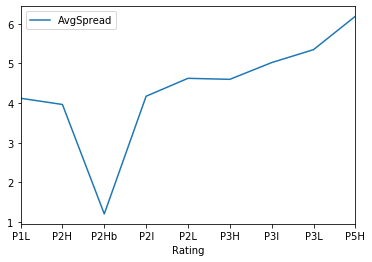

In [6]:
#vxticks = [x for x in ms_averages['Rating'].values if x != 'NR']
ax = ms_averages[ms_averages['Rating']!='NR'].plot(x="Rating",y='AvgSpread')

# ms_averages

In [7]:
tpm = tprefs.merge(ms_averages,on='Rating')

In [8]:
tpm.head()

,Ticker,Rating,Spread,Price,MSpread,AvgSpread
0,AZP.PR.C,P5H,418.0,18.60,6.1895,6.1895
1,AIM.PR.B,NR,375.0,16.33,6.6223,6.6223
2,BPO.PR.S,P3I,348.0,19.15,5.0502,5.0206
3,FFH.PR.D,P3I,315.0,18.50,4.8400,5.0206
4,FFH.PR.J,P3I,285.0,17.28,4.8649,5.0206


In [9]:
tpm['SpreadToAverage'] = tpm['MSpread'] - tpm['AvgSpread']

In [10]:
# Now that we have Market Spread, figure out total gain after a year, and an assumed
# Tbill rate (say 1.4)
#
# annualized_gain_cg_and_dividend_decimal(num_years, current_price, tbill_rate_in_percent,
#                            market_spread_in_percent, issue_spread_in_bips, par=25)
#
#
        
create_tbill_scenarios_from_mspread(-0.1, tprefs,False)

# float_capital_gain_given_tbill_and_market_spread(current_price, 
#                                                    tbill_rate_in_percent,
#                                                     market_spread_in_percent,
#                                                   issue_spread_in_bips,

#tprefs["CG"] = [float_capital_gain_given_tbill_and_market_spread(price, 1.4, 
#                                                  mspread,spread)/price for (price,mspread,spread) in
#                 zip(tprefs['Price'], tprefs['MSpread'], tprefs['Spread'])] 
# tprefs.sort_values(by=['Scn1'], ascending=False).head()
tprefs.sort_values(by='Expected_Gain',ascending=False).head(15)

,Ticker,Rating,Spread,Price,MSpread,EffMSpread,MSpread_Delta,Expected_Gain,Constant,PriceConstant,SlightDrop,PriceSlightDrop,BigDrop,PriceBigDrop,Panic,PricePanic
12,AZP.PR.C,P5H,418.0,18.60,6.1895,6.0895,-0.1,0.067357,0.091394,18.839925,0.076402,18.626077,0.058070,18.360108,0.031663,17.968923
22,BMO.PR.A,P2Hb,115.0,24.51,1.2062,1.1062,-0.1,0.063780,0.064804,25.395850,0.063828,25.436916,0.063192,25.496329,0.063596,25.606245
19,BNS.PR.F,P2Hb,134.0,24.56,1.3937,1.2937,-0.1,0.063106,0.064409,25.391881,0.063302,25.429706,0.062441,25.483561,0.062320,25.580579
13,AIM.PR.B,NR,375.0,16.33,6.6223,6.5223,-0.1,0.061376,0.095045,16.529582,0.074041,16.251594,0.048363,15.907272,0.011401,15.403680
14,BPO.PR.S,P3I,348.0,19.15,5.0502,4.9502,-0.1,0.057524,0.082227,19.439654,0.066945,19.211993,0.048041,18.924994,0.020361,18.494921
17,BNS.PR.D,P2Hb,100.0,24.90,1.0107,0.9107,-0.1,0.056817,0.060843,25.750000,0.058233,25.750000,0.055221,25.750000,0.051205,25.750000
15,FFH.PR.D,P3I,315.0,18.50,4.8400,4.7400,-0.1,0.051874,0.080625,18.789062,0.062895,18.526059,0.040864,18.193493,0.008406,17.693015
20,FFH.PR.J,P3I,285.0,17.28,4.8649,4.7649,-0.1,0.045171,0.080811,17.548911,0.058864,17.234667,0.031537,16.837457,-0.008825,16.240004
21,IFC.PR.D,P2I,266.0,18.00,4.3400,4.2400,-0.1,0.043071,0.076949,18.305085,0.056192,17.996454,0.030166,17.602996,-0.008664,17.004049
24,BRF.PR.B,P3H,262.0,16.98,4.6415,4.5415,-0.1,0.040404,0.079145,17.253890,0.055355,16.914920,0.025617,16.484977,-0.018542,15.835162


In [11]:
# spread deltas
SPREAD_DELTAS = [ 0.2, 0, -0.2, -.4]

## HACK here
foo = pd.concat([create_tbill_scenarios_from_mspread(delta,tprefs.copy(),True) 
                      for delta in SPREAD_DELTAS], axis = 0)
foo.reset_index(drop=True, inplace=True)

foo

,Ticker,Rating,Spread,Price,MSpread,EffMSpread,MSpread_Delta,Expected_Gain,Constant,PriceConstant,SlightDrop,PriceSlightDrop,BigDrop,PriceBigDrop,Panic,PricePanic
0,AZP.PR.C,P5H,418.0,18.60,6.1895,6.3895,0.2,0.028322,0.053644,18.137773,0.037835,17.908723,0.018531,17.624675,-0.009218,17.208548
1,AIM.PR.B,NR,375.0,16.33,6.6223,6.8223,0.2,0.024802,0.059245,15.944968,0.037730,15.658636,0.011476,15.304899,-0.026218,14.789360
2,BPO.PR.S,P3I,348.0,19.15,5.0502,5.2502,0.2,0.011571,0.038157,18.595699,0.021687,18.345313,0.001354,18.030928,-0.028332,17.562435
3,FFH.PR.D,P3I,315.0,18.50,4.8400,5.0400,0.2,0.004550,0.035149,17.947761,0.016246,17.663043,-0.007186,17.304560,-0.041579,16.768293
4,BNS.PR.D,P2Hb,100.0,24.90,1.0107,1.2107,0.2,-0.060316,-0.042969,23.165082,-0.052918,22.982342,-0.066450,22.720388,-0.089632,22.243157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,FTS.PR.I,P3H,145.0,12.95,4.3439,3.9439,-0.4,0.054373,0.131411,13.874266,0.084591,13.332959,0.025215,12.639029,-0.064724,11.574323
116,MFC.PR.P,P2I,141.0,13.55,4.0042,3.6042,-0.4,0.058634,0.132628,14.579613,0.087875,14.038208,0.030749,13.339144,-0.056607,12.255471
117,SLF.PR.J,P1L,141.0,13.41,4.0633,3.4633,-0.4,0.100137,0.174353,14.980579,0.129562,14.444924,0.072223,13.751014,-0.015829,12.670238
118,GWO.PR.O,P2H,130.0,13.70,3.7415,3.3415,-0.4,0.058268,0.133983,14.795561,0.088394,14.236001,0.029850,13.508950,-0.060464,12.371644


In [12]:
NUM_RANKS_TO_KEEP = 8

scenario_names = TBILL_SCN.keys()
rank_names = ['Rank' + x for x in scenario_names]

def rank_group(df):
    for rank_name,scenario_name in zip(rank_names, scenario_names):
        df[rank_name] = [1 if x in df[scenario_name].nlargest(n=NUM_RANKS_TO_KEEP).values else 0 
                         for x in df[scenario_name]]
    df['RankSum'] = df[rank_names].sum(axis=1)
    return df

In [13]:
ranked = foo.groupby(['MSpread_Delta']).apply(rank_group)
ranked[(ranked['RankSum']) > 0 ][
    ['Ticker','MSpread_Delta','RankSum'] + rank_names].sort_values(
    by='Ticker')



,Ticker,MSpread_Delta,RankSum,RankConstant,RankSlightDrop,RankBigDrop,RankPanic
1,AIM.PR.B,0.2,4,1,1,1,1
91,AIM.PR.B,-0.4,4,1,1,1,1
61,AIM.PR.B,-0.2,4,1,1,1,1
31,AIM.PR.B,0.0,4,1,1,1,1
69,ALA.PR.B,-0.2,1,1,0,0,0
9,ALA.PR.B,0.2,3,1,1,1,0
39,ALA.PR.B,0.0,2,1,1,0,0
0,AZP.PR.C,0.2,4,1,1,1,1
90,AZP.PR.C,-0.4,4,1,1,1,1
30,AZP.PR.C,0.0,4,1,1,1,1


In [14]:
baz = ranked[['Ticker','RankSum','Expected_Gain']].groupby(['Ticker']).agg(
    TotalRankSum=('RankSum','sum'),AvgExpectedGain=('Expected_Gain','mean')).reset_index().sort_values(by='AvgExpectedGain',ascending=False)
baz     


,Ticker,TotalRankSum,AvgExpectedGain
24,SLF.PR.K,16,0.069949
2,AZP.PR.C,16,0.068282
0,AIM.PR.B,16,0.062193
8,BPO.PR.S,12,0.058825
11,FFH.PR.D,12,0.053263
14,FFH.PR.J,6,0.046539
19,IFC.PR.D,5,0.044721
9,BRF.PR.B,2,0.041877
1,ALA.PR.B,6,0.040202
23,SLF.PR.J,8,0.039337


In [15]:
foo = pdr.get_data_yahoo('SLF-pj.TO', 
                          start=datetime.datetime(2019, 12, 1), 
                         end=datetime.datetime(2020, 1, 3))
foo.tail(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,13.27,13.25,13.25,13.26,1400,13.26
2020-01-03,13.47,13.40,13.47,13.41,1600,13.41


In [16]:

convert_ticker_to_yahoo("SLF.PR.K")

'SLF-pK.TO'

In [17]:
floats['YahooTicker'] = [convert_ticker_to_yahoo(x) for x in floats['Ticker']]

In [18]:
today = date.today()


In [19]:
foo = pdr.get_data_yahoo('TA-pE.TO', start=datetime.datetime(2019,12,31),end= today)


In [20]:
foo


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,12.00,12.00,12.00,12.00,16038,12.00
2020-01-02,12.15,12.15,12.15,12.15,100,12.15
2020-01-03,12.25,12.13,12.25,12.20,1000,12.20


In [24]:
floats['NewPrice'] = [fetch_last_close_in_dollars(x) for x in floats['Ticker']]

In [25]:
floats


,Ticker,Rating,Spread,Price,Reference,Mult,YahooTicker,NewPrice
0,TRI.PR.B,P3H,0.0,13.22,P,0.7,TRI-pB.TO,13.22
1,PWF.PR.A,P2L,NaN,12.86,P,0.7,PWF-pA.TO,12.86
2,BAM.PR.E,P2L,NaN,16.19,P,1.0,BAM-pE.TO,16.19
3,BCE.PR.D,P3I,0.0,15.41,P,1.0,BCE-pD.TO,15.41
4,BCE.PR.B,P3I,0.0,15.44,P,1.0,BCE-pB.TO,15.44
5,BCE.PR.Y,P3I,0.0,15.39,P,1.0,BCE-pY.TO,15.39
6,BCE.PR.S,P3I,0.0,15.39,P,1.0,BCE-pS.TO,15.39
7,BCE.PR.J,P3I,0.0,15.38,P,1.0,BCE-pJ.TO,15.38
8,BAM.PR.B,P2L,NaN,11.85,P,0.7,BAM-pB.TO,11.85
9,BAM.PR.C,P2L,NaN,11.85,P,0.7,BAM-pC.TO,11.85


In [28]:
baz = baz.merge(floats[['Ticker','Rating']], on='Ticker', how='left')

In [29]:
baz

,Ticker,TotalRankSum,AvgExpectedGain,Rating
0,SLF.PR.K,16,0.069949,P1L
1,AZP.PR.C,16,0.068282,P5H
2,AIM.PR.B,16,0.062193,NR
3,BPO.PR.S,12,0.058825,P3I
4,FFH.PR.D,12,0.053263,P3I
5,FFH.PR.J,6,0.046539,P3I
6,IFC.PR.D,5,0.044721,P2I
7,BRF.PR.B,2,0.041877,P3H
8,ALA.PR.B,6,0.040202,P3L
9,SLF.PR.J,8,0.039337,P1L
